In [239]:
# load dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [240]:
tx_energy = pd.read_csv("texas_energy_production.csv")  #usecols=[1],engine='python'
# texas_energy.set_index('Years', inplace=True)
tx_energy.head()

,Unnamed: 0,Years,Coal_prod,Gas_prod,Oil_prod,Renewable_en_prod,Total_en_prod,Total_en_consumption
0,0,1960,26409.0,6602696.0,5379378.0,50155.0,12058639.0,4416216.0
1,1,1961,26535.0,6682140.0,5447308.0,52023.0,12208006.0,4447880.0
2,2,1962,25855.0,6812787.0,5471272.0,47721.0,12357635.0,4640675.0
3,3,1963,27441.0,6952455.0,5671135.0,42718.0,12693749.0,4894089.0
4,4,1964,28839.0,7311876.0,5739216.0,43884.0,13123816.0,5012683.0


# Texas Coal forcast model 

In [241]:
tx_coal = tx_energy[["Coal_prod"]]
tx_coal.head()
# tx_coal.shape

,Coal_prod
0,26409.0
1,26535.0
2,25855.0
3,27441.0
4,28839.0


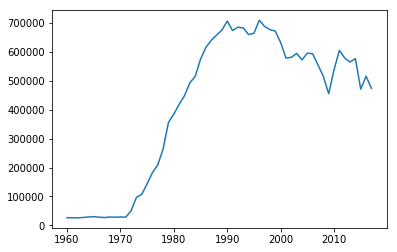

In [242]:
plt.plot(tx_energy.Years,tx_coal.Coal_prod)

In [243]:
tx_coal = tx_coal.values
tx_coal = tx_coal.astype('float32')

In [244]:
scaler = MinMaxScaler(feature_range=(0, 1))
tx_coal = scaler.fit_transform(tx_coal)

In [245]:
# split into train and test sets
train_size = int(len(tx_coal) * 0.67)
test_size = len(tx_coal) - train_size
train, test = tx_coal[0:train_size,:], tx_coal[train_size:len(tx_coal),:]

In [246]:
# convert an array of values into a dataset matrix
def create_dataset(state_data, look_back=1):
	dataX, dataY = [], []
	for i in range(len(state_data)-look_back-1):
		a = state_data[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(state_data[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [247]:
# reshape into X=t and Y=t+1
look_back= 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [248]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [249]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.2570
Epoch 2/100
 - 0s - loss: 0.2116
Epoch 3/100
 - 0s - loss: 0.1713
Epoch 4/100
 - 0s - loss: 0.1391
Epoch 5/100
 - 0s - loss: 0.1124
Epoch 6/100
 - 0s - loss: 0.0914
Epoch 7/100
 - 0s - loss: 0.0777
Epoch 8/100
 - 0s - loss: 0.0652
Epoch 9/100
 - 0s - loss: 0.0564
Epoch 10/100
 - 0s - loss: 0.0508
Epoch 11/100
 - 0s - loss: 0.0449
Epoch 12/100
 - 0s - loss: 0.0407
Epoch 13/100
 - 0s - loss: 0.0360
Epoch 14/100
 - 0s - loss: 0.0320
Epoch 15/100
 - 0s - loss: 0.0284
Epoch 16/100
 - 0s - loss: 0.0252
Epoch 17/100
 - 0s - loss: 0.0220
Epoch 18/100
 - 0s - loss: 0.0191
Epoch 19/100
 - 0s - loss: 0.0166
Epoch 20/100
 - 0s - loss: 0.0144
Epoch 21/100
 - 0s - loss: 0.0120
Epoch 22/100
 - 0s - loss: 0.0102
Epoch 23/100
 - 0s - loss: 0.0086
Epoch 24/100
 - 0s - loss: 0.0073
Epoch 25/100
 - 0s - loss: 0.0061
Epoch 26/100
 - 0s - loss: 0.0052
Epoch 27/100
 - 0s - loss: 0.0044
Epoch 28/100
 - 0s - loss: 0.0037
Epoch 29/100
 - 0s - loss: 0.0032
Epoch 30/100
 - 0s - lo

In [250]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [251]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21231.58 RMSE
Test Score: 56486.27 RMSE


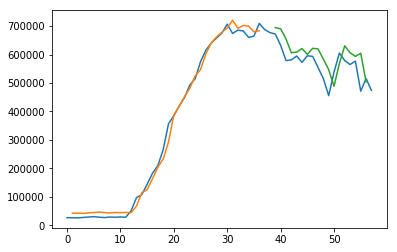

In [252]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(tx_coal)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(tx_coal)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(tx_coal)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(tx_coal))
plt.plot(trainPredictPlot)

plt.plot(testPredictPlot)
plt.show()

In [253]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX, trainY = create_dataset(tx_coal, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

# re-create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.5721
Epoch 2/100
 - 0s - loss: 0.1807
Epoch 3/100
 - 0s - loss: 0.0626
Epoch 4/100
 - 0s - loss: 0.0435
Epoch 5/100
 - 0s - loss: 0.0345
Epoch 6/100
 - 0s - loss: 0.0269
Epoch 7/100
 - 0s - loss: 0.0210
Epoch 8/100
 - 0s - loss: 0.0163
Epoch 9/100
 - 0s - loss: 0.0129
Epoch 10/100
 - 0s - loss: 0.0105
Epoch 11/100
 - 0s - loss: 0.0083
Epoch 12/100
 - 0s - loss: 0.0071
Epoch 13/100
 - 0s - loss: 0.0061
Epoch 14/100
 - 0s - loss: 0.0058
Epoch 15/100
 - 0s - loss: 0.0055
Epoch 16/100
 - 0s - loss: 0.0045
Epoch 17/100
 - 0s - loss: 0.0048
Epoch 18/100
 - 0s - loss: 0.0046
Epoch 19/100
 - 0s - loss: 0.0042
Epoch 20/100
 - 0s - loss: 0.0042
Epoch 21/100
 - 0s - loss: 0.0042
Epoch 22/100
 - 0s - loss: 0.0042
Epoch 23/100
 - 0s - loss: 0.0038
Epoch 24/100
 - 0s - loss: 0.0042
Epoch 25/100
 - 0s - loss: 0.0037
Epoch 26/100
 - 0s - loss: 0.0036
Epoch 27/100
 - 0s - loss: 0.0037
Epoch 28/100
 - 0s - loss: 0.0035
Epoch 29/100
 - 0s - loss: 0.0033
Epoch 30/100
 - 0s - lo

58


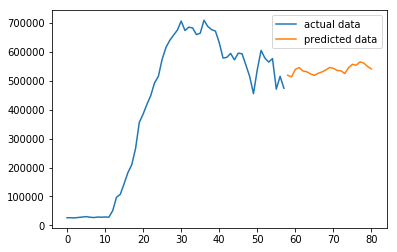

In [254]:
# making future prediction
flatten_state_data = tx_coal.reshape(-1)
val = flatten_state_data[-look_back:] # last batch in the training data
pred_list = []
for i in range(23): # predict the next 23 points
    pred = model.predict(val.reshape(1,1,look_back))
    pred_list = np.append(pred_list,pred)
    val = np.append(np.delete(val, 0), pred) # update the data batch to be fed in the next iteration
pred_list = pred_list.reshape(pred_list.shape[0],1)

# invert prediction
pred_list = scaler.inverse_transform(pred_list)

# plot
data_len = len(tx_coal)
print(data_len)
plt.plot(list(range(data_len)),scaler.inverse_transform(tx_coal),label="actual data")
plt.plot(list(range(data_len,data_len+len(pred_list))),pred_list,label="predicted data")
plt.legend()
plt.show()

Texas Coal production 1960-2040 dataframe

In [255]:
L = pred_list
L

array([[519282.30956575],
       [513598.60495524],
       [539532.70513731],
       [545763.21993824],
       [533985.18352526],
       [531407.36405619],
       [523771.74388336],
       [519019.92706214],
       [525828.26200614],
       [530781.37865154],
       [537427.12527601],
       [546084.07718835],
       [543274.19243614],
       [535862.36550914],
       [534747.71866895],
       [525340.4562986 ],
       [545279.97811336],
       [557064.61585659],
       [553878.04778967],
       [565398.02108797],
       [561198.67856152],
       [549462.61356938],
       [541244.40562605]])

In [256]:
tx_coal_pre = pd.DataFrame(L, columns=["Coal_prod"])
tx_coal_pre.head()

,Coal_prod
0,519282.309566
1,513598.604955
2,539532.705137
3,545763.219938
4,533985.183525


In [257]:
pre_yrs = numpy.arange(2018, 2041, 1).tolist()
pre_yrs = pd.DataFrame({"Years":pre_yrs})
pre_yrs.head()

,Years
0,2018
1,2019
2,2020
3,2021
4,2022


In [258]:

coal_pred = pd.concat([pre_yrs, tx_coal_pre], axis=1, sort=False)
coal_pred.head()

,Years,Coal_prod
0,2018,519282.309566
1,2019,513598.604955
2,2020,539532.705137
3,2021,545763.219938
4,2022,533985.183525


In [259]:
tx_coal = tx_energy[["Years", "Coal_prod"]]
tx_coal.head()

,Years,Coal_prod
0,1960,26409.0
1,1961,26535.0
2,1962,25855.0
3,1963,27441.0
4,1964,28839.0


In [260]:
TexasCoal_prod_pre = pd.concat([tx_coal, coal_pred])
TexasCoal_prod_pre.head()

,Years,Coal_prod
0,1960,26409.0
1,1961,26535.0
2,1962,25855.0
3,1963,27441.0
4,1964,28839.0


# Texas Gas Forcasting model

In [261]:
tx_gas = tx_energy[["Gas_prod"]]
tx_gas.head()

,Gas_prod
0,6602696.0
1,6682140.0
2,6812787.0
3,6952455.0
4,7311876.0


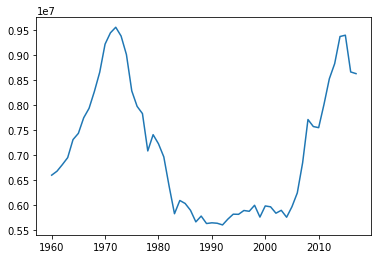

In [262]:
plt.plot(tx_energy.Years,tx_gas.Gas_prod)

In [263]:

scaler_tx_gas  = MinMaxScaler(feature_range=(0, 1))
tx_gas = scaler_tx_gas.fit_transform(tx_gas)

In [264]:
# split into train and test sets
train_size_tx_gas  = int(len(tx_gas ) * 0.67)
test_size_tx_gas  = len(tx_gas) - train_size_tx_gas 
train_tx_gas , test_tx_gas  = tx_gas [0:train_size_tx_gas,:], tx_gas [train_size_tx_gas :len(tx_gas),:]

In [265]:
# convert an array of values into a dataset matrix
def create_tx_gas(tx_gas, look_back=1):
	dataX_tx_gas, dataY_tx_gas = [], []
	for i_tx_gas in range(len(tx_gas)-look_back-1):
		a_tx_gas = tx_gas[i_tx_gas:(i_tx_gas+look_back), 0]
		dataX_tx_gas.append(a_tx_gas)
		dataY_tx_gas.append(tx_gas[i_tx_gas + look_back, 0])
	return numpy.array(dataX_tx_gas), numpy.array(dataY_tx_gas)

In [266]:
# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_gas, trainY_tx_gas = create_tx_gas(train_tx_gas, look_back)
testX_tx_gas, testY_tx_gas = create_tx_gas(test_tx_gas, look_back)

In [267]:
# reshape input to be [samples, time steps, features]
trainX_tx_gas = numpy.reshape(trainX_tx_gas, (trainX_tx_gas.shape[0], 1, trainX_tx_gas.shape[1]))
testX_tx_gas = numpy.reshape(testX_tx_gas, (testX_tx_gas.shape[0], 1, testX_tx_gas.shape[1]))

In [268]:
# create and fit the LSTM network
model_tx_gas = Sequential()
model_tx_gas.add(LSTM(4, input_shape=(1, look_back)))
model_tx_gas.add(Dense(1))
model_tx_gas.compile(loss='mean_squared_error', optimizer='adam')
model_tx_gas.fit(trainX_tx_gas, trainY_tx_gas, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.2386
Epoch 2/100
 - 0s - loss: 0.2094
Epoch 3/100
 - 0s - loss: 0.1856
Epoch 4/100
 - 0s - loss: 0.1654
Epoch 5/100
 - 0s - loss: 0.1495
Epoch 6/100
 - 0s - loss: 0.1354
Epoch 7/100
 - 0s - loss: 0.1238
Epoch 8/100
 - 0s - loss: 0.1143
Epoch 9/100
 - 0s - loss: 0.1067
Epoch 10/100
 - 0s - loss: 0.0994
Epoch 11/100
 - 0s - loss: 0.0941
Epoch 12/100
 - 0s - loss: 0.0890
Epoch 13/100
 - 0s - loss: 0.0846
Epoch 14/100
 - 0s - loss: 0.0805
Epoch 15/100
 - 0s - loss: 0.0771
Epoch 16/100
 - 0s - loss: 0.0740
Epoch 17/100
 - 0s - loss: 0.0705
Epoch 18/100
 - 0s - loss: 0.0675
Epoch 19/100
 - 0s - loss: 0.0646
Epoch 20/100
 - 0s - loss: 0.0620
Epoch 21/100
 - 0s - loss: 0.0592
Epoch 22/100
 - 0s - loss: 0.0564
Epoch 23/100
 - 0s - loss: 0.0531
Epoch 24/100
 - 0s - loss: 0.0505
Epoch 25/100
 - 0s - loss: 0.0475
Epoch 26/100
 - 0s - loss: 0.0446
Epoch 27/100
 - 0s - loss: 0.0418
Epoch 28/100
 - 0s - loss: 0.0390
Epoch 29/100
 - 0s - loss: 0.0364
Epoch 30/100
 - 0s - lo

In [269]:
# make predictions
trainPredict_tx_gas = model_tx_gas.predict(trainX_tx_gas)
testPredict_tx_gas = model_tx_gas.predict(testX_tx_gas)

In [270]:
# invert predictions
trainPredict_tx_gas = scaler_tx_gas.inverse_transform(trainPredict_tx_gas)
trainY_tx_gas = scaler_tx_gas.inverse_transform([trainY_tx_gas])
testPredict_tx_gas = scaler_tx_gas.inverse_transform(testPredict_tx_gas)
testY_tx_gas = scaler_tx_gas.inverse_transform([testY_tx_gas])
# calculate root mean squared error
trainScore_tx_gas = math.sqrt(mean_squared_error(trainY_tx_gas[0], trainPredict_tx_gas[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_gas))
testScore_tx_gas = math.sqrt(mean_squared_error(testY_tx_gas[0], testPredict_tx_gas[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_gas))

Train Score: 302334.66 RMSE
Test Score: 390353.91 RMSE


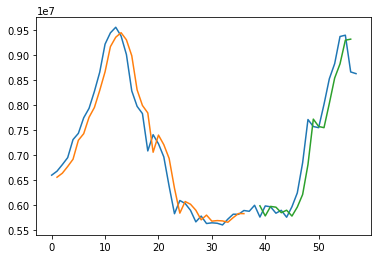

In [271]:
# shift train predictions for plotting
trainPredictPlot_tx_gas = numpy.empty_like(tx_gas)
trainPredictPlot_tx_gas[:, :] = numpy.nan
trainPredictPlot_tx_gas[look_back:len(trainPredict_tx_gas)+look_back, :] = trainPredict_tx_gas
# shift test predictions for plotting
testPredictPlot_tx_gas = numpy.empty_like(tx_gas)
testPredictPlot_tx_gas[:, :] = numpy.nan
testPredictPlot_tx_gas[len(trainPredict_tx_gas)+(look_back*2)+1:len(tx_gas)-1, :] = testPredict_tx_gas
# plot baseline and predictions
plt.plot(scaler_tx_gas.inverse_transform(tx_gas))
plt.plot(trainPredictPlot_tx_gas)
plt.plot(testPredictPlot_tx_gas)
plt.show()

In [272]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_gas, trainY_tx_gas = create_tx_gas(tx_gas, look_back)
trainX_tx_gas = numpy.reshape(trainX_tx_gas, (trainX_tx_gas.shape[0], 1, trainX_tx_gas.shape[1]))

# re-create and fit the LSTM network
model_tx_gas = Sequential()
model_tx_gas.add(LSTM(4, input_shape=(1, look_back)))
model_tx_gas.add(Dense(1))
model_tx_gas.compile(loss='mean_squared_error', optimizer='adam')
model_tx_gas.fit(trainX_tx_gas, trainY_tx_gas, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.1850
Epoch 2/100
 - 0s - loss: 0.1369
Epoch 3/100
 - 0s - loss: 0.1089
Epoch 4/100
 - 0s - loss: 0.0871
Epoch 5/100
 - 0s - loss: 0.0687
Epoch 6/100
 - 0s - loss: 0.0549
Epoch 7/100
 - 0s - loss: 0.0438
Epoch 8/100
 - 0s - loss: 0.0356
Epoch 9/100
 - 0s - loss: 0.0275
Epoch 10/100
 - 0s - loss: 0.0229
Epoch 11/100
 - 0s - loss: 0.0194
Epoch 12/100
 - 0s - loss: 0.0168
Epoch 13/100
 - 0s - loss: 0.0147
Epoch 14/100
 - 0s - loss: 0.0127
Epoch 15/100
 - 0s - loss: 0.0120
Epoch 16/100
 - 0s - loss: 0.0108
Epoch 17/100
 - 0s - loss: 0.0103
Epoch 18/100
 - 0s - loss: 0.0096
Epoch 19/100
 - 0s - loss: 0.0091
Epoch 20/100
 - 0s - loss: 0.0087
Epoch 21/100
 - 0s - loss: 0.0084
Epoch 22/100
 - 0s - loss: 0.0083
Epoch 23/100
 - 0s - loss: 0.0081
Epoch 24/100
 - 0s - loss: 0.0078
Epoch 25/100
 - 0s - loss: 0.0078
Epoch 26/100
 - 0s - loss: 0.0075
Epoch 27/100
 - 0s - loss: 0.0072
Epoch 28/100
 - 0s - loss: 0.0072
Epoch 29/100
 - 0s - loss: 0.0070
Epoch 30/100
 - 0s - lo

58


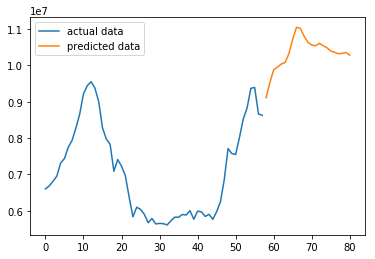

In [273]:
# making future prediction
flatten_tx_gas = tx_gas.reshape(-1)
val_tx_gas = flatten_tx_gas[-look_back:] # last batch in the training data
pred_list_tx_gas = []
for i_tx_gas in range(23): # predict the next 23 points
    pred_tx_gas = model_tx_gas.predict(val_tx_gas.reshape(1,1,look_back))
    pred_list_tx_gas = np.append(pred_list_tx_gas,pred_tx_gas)
    val_tx_gas = np.append(np.delete(val_tx_gas, 0),pred_tx_gas) # update the data batch to be fed in the next iteration
pred_list_tx_gas = pred_list_tx_gas.reshape(pred_list_tx_gas.shape[0],1)

# invert prediction
pred_list_tx_gas = scaler_tx_gas.inverse_transform(pred_list_tx_gas)

# plot
tx_gas_len = len(tx_gas)
print(tx_gas_len)
plt.plot(list(range(tx_gas_len)),scaler_tx_gas.inverse_transform(tx_gas),label="actual data")
plt.plot(list(range(tx_gas_len,tx_gas_len+len(pred_list_tx_gas))),pred_list_tx_gas,label="predicted data")
plt.legend()
plt.show()

texas gas production 1965-2040

In [274]:
L_gas = pred_list_tx_gas
tx_gas_pre = pd.DataFrame(L, columns=["Gas_prod"])
tx_gas_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
gas_pred = pd.concat([pre_yrs, tx_gas_pre], axis=1, sort=False)
gas_pred.head()
tx_gas = tx_energy[["Years", "Gas_prod"]]
tx_gas.head()
Texasgas_prod_pre = pd.concat([tx_gas, gas_pred])
Texasgas_prod_pre.head()

,Years,Gas_prod
0,1960,6602696.0
1,1961,6682140.0
2,1962,6812787.0
3,1963,6952455.0
4,1964,7311876.0


# Texas Oil Forcasting  model 

In [275]:
tx_oil = tx_energy[["Oil_prod"]]
tx_oil.head()

,Oil_prod
0,5379378.0
1,5447308.0
2,5471272.0
3,5671135.0
4,5739216.0


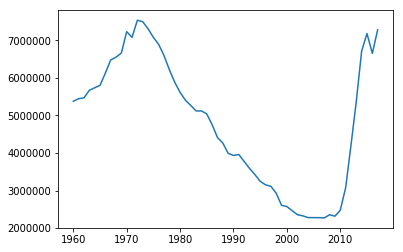

In [276]:
tx_oil = tx_energy[["Oil_prod"]]
tx_oil.head()
plt.plot(tx_energy.Years,tx_oil.Oil_prod)


In [277]:
scaler_tx_oil  = MinMaxScaler(feature_range=(0, 1))
tx_oil = scaler_tx_oil.fit_transform(tx_oil)

# split into train and test sets
train_size_tx_oil  = int(len(tx_oil) * 0.67)
test_size_tx_oil  = len(tx_oil) - train_size_tx_oil 
train_tx_oil , test_tx_oil  = tx_oil [0:train_size_tx_oil,:], tx_oil [train_size_tx_oil :len(tx_oil),:]

# convert an array of values into a dataset matrix
def create_tx_oil(tx_oil, look_back=1):
	dataX_tx_oil, dataY_tx_oil = [], []
	for i_tx_oil in range(len(tx_oil)-look_back-1):
		a_tx_oil = tx_oil[i_tx_oil:(i_tx_oil+look_back), 0]
		dataX_tx_oil.append(a_tx_oil)
		dataY_tx_oil.append(tx_oil[i_tx_oil + look_back, 0])
	return numpy.array(dataX_tx_oil), numpy.array(dataY_tx_oil)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_oil, trainY_tx_oil = create_tx_oil(train_tx_oil, look_back)
testX_tx_oil, testY_tx_oil = create_tx_oil(test_tx_oil, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_oil = numpy.reshape(trainX_tx_oil, (trainX_tx_oil.shape[0], 1, trainX_tx_oil.shape[1]))
testX_tx_oil = numpy.reshape(testX_tx_oil, (testX_tx_oil.shape[0], 1, testX_tx_oil.shape[1]))

# create and fit the LSTM network
model_tx_oil = Sequential()
model_tx_oil.add(LSTM(4, input_shape=(1, look_back)))
model_tx_oil.add(Dense(1))
model_tx_oil.compile(loss='mean_squared_error', optimizer='adam')
model_tx_oil.fit(trainX_tx_oil, trainY_tx_oil, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.3980
Epoch 2/100
 - 0s - loss: 0.3277
Epoch 3/100
 - 0s - loss: 0.2664
Epoch 4/100
 - 0s - loss: 0.2130
Epoch 5/100
 - 0s - loss: 0.1663
Epoch 6/100
 - 0s - loss: 0.1285
Epoch 7/100
 - 0s - loss: 0.0957
Epoch 8/100
 - 0s - loss: 0.0723
Epoch 9/100
 - 0s - loss: 0.0579
Epoch 10/100
 - 0s - loss: 0.0459
Epoch 11/100
 - 0s - loss: 0.0395
Epoch 12/100
 - 0s - loss: 0.0361
Epoch 13/100
 - 0s - loss: 0.0338
Epoch 14/100
 - 0s - loss: 0.0324
Epoch 15/100
 - 0s - loss: 0.0315
Epoch 16/100
 - 0s - loss: 0.0304
Epoch 17/100
 - 0s - loss: 0.0297
Epoch 18/100
 - 0s - loss: 0.0289
Epoch 19/100
 - 0s - loss: 0.0281
Epoch 20/100
 - 0s - loss: 0.0273
Epoch 21/100
 - 0s - loss: 0.0265
Epoch 22/100
 - 0s - loss: 0.0259
Epoch 23/100
 - 0s - loss: 0.0249
Epoch 24/100
 - 0s - loss: 0.0243
Epoch 25/100
 - 0s - loss: 0.0232
Epoch 26/100
 - 0s - loss: 0.0225
Epoch 27/100
 - 0s - loss: 0.0217
Epoch 28/100
 - 0s - loss: 0.0210
Epoch 29/100
 - 0s - loss: 0.0201
Epoch 30/100
 - 0s - lo

In [278]:
# make predictions
trainPredict_tx_oil = model_tx_oil.predict(trainX_tx_oil)
testPredict_tx_oil = model_tx_oil.predict(testX_tx_oil)
# invert predictions
trainPredict_tx_oil = scaler_tx_oil.inverse_transform(trainPredict_tx_oil)
trainY_tx_oil = scaler_tx_oil.inverse_transform([trainY_tx_oil])
testPredict_tx_oil = scaler_tx_oil.inverse_transform(testPredict_tx_oil)
testY_tx_oil = scaler_tx_oil.inverse_transform([testY_tx_oil])
# calculate root mean squared error
trainScore_tx_oil = math.sqrt(mean_squared_error(trainY_tx_oil[0], trainPredict_tx_oil[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_oil))
testScore_tx_oil = math.sqrt(mean_squared_error(testY_tx_oil[0], testPredict_tx_oil[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_oil))

Train Score: 218043.25 RMSE
Test Score: 585042.74 RMSE


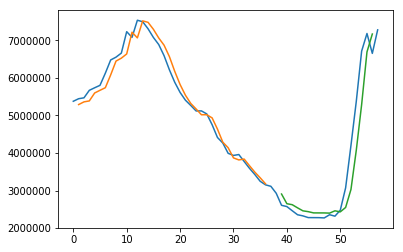

In [279]:
# shift train predictions for plotting
trainPredictPlot_tx_oil = numpy.empty_like(tx_oil)
trainPredictPlot_tx_oil[:, :] = numpy.nan
trainPredictPlot_tx_oil[look_back:len(trainPredict_tx_oil)+look_back, :] = trainPredict_tx_oil
# shift test predictions for plotting
testPredictPlot_tx_oil = numpy.empty_like(tx_oil)
testPredictPlot_tx_oil[:, :] = numpy.nan
testPredictPlot_tx_oil[len(trainPredict_tx_oil)+(look_back*2)+1:len(tx_oil)-1, :] = testPredict_tx_oil
# plot baseline and predictions
plt.plot(scaler_tx_oil.inverse_transform(tx_oil))
plt.plot(trainPredictPlot_tx_oil)
plt.plot(testPredictPlot_tx_oil)
plt.show()

In [280]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_oil, trainY_tx_oil = create_tx_gas(tx_oil, look_back)
trainX_tx_oil = numpy.reshape(trainX_tx_oil, (trainX_tx_oil.shape[0], 1, trainX_tx_oil.shape[1]))

# re-create and fit the LSTM network
model_tx_oil = Sequential()
model_tx_oil.add(LSTM(4, input_shape=(1, look_back)))
model_tx_oil.add(Dense(1))
model_tx_oil.compile(loss='mean_squared_error', optimizer='adam')
model_tx_oil.fit(trainX_tx_oil, trainY_tx_oil, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.1110
Epoch 2/100
 - 0s - loss: 0.0937
Epoch 3/100
 - 0s - loss: 0.0889
Epoch 4/100
 - 0s - loss: 0.0856
Epoch 5/100
 - 0s - loss: 0.0830
Epoch 6/100
 - 0s - loss: 0.0811
Epoch 7/100
 - 0s - loss: 0.0788
Epoch 8/100
 - 0s - loss: 0.0762
Epoch 9/100
 - 0s - loss: 0.0739
Epoch 10/100
 - 0s - loss: 0.0717
Epoch 11/100
 - 0s - loss: 0.0686
Epoch 12/100
 - 0s - loss: 0.0659
Epoch 13/100
 - 0s - loss: 0.0633
Epoch 14/100
 - 0s - loss: 0.0601
Epoch 15/100
 - 0s - loss: 0.0566
Epoch 16/100
 - 0s - loss: 0.0536
Epoch 17/100
 - 0s - loss: 0.0488
Epoch 18/100
 - 0s - loss: 0.0459
Epoch 19/100
 - 0s - loss: 0.0416
Epoch 20/100
 - 0s - loss: 0.0381
Epoch 21/100
 - 0s - loss: 0.0336
Epoch 22/100
 - 0s - loss: 0.0298
Epoch 23/100
 - 0s - loss: 0.0270
Epoch 24/100
 - 0s - loss: 0.0232
Epoch 25/100
 - 0s - loss: 0.0205
Epoch 26/100
 - 0s - loss: 0.0179
Epoch 27/100
 - 0s - loss: 0.0154
Epoch 28/100
 - 0s - loss: 0.0147
Epoch 29/100
 - 0s - loss: 0.0122
Epoch 30/100
 - 0s - lo

58


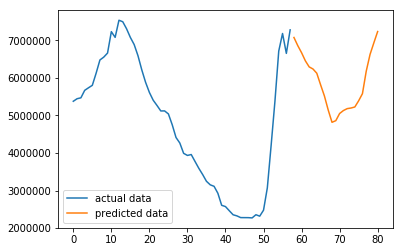

In [281]:
# making future prediction
flatten_tx_oil = tx_oil.reshape(-1)
val_tx_oil = flatten_tx_oil[-look_back:] # last batch in the training data
pred_list_tx_oil = []
for i_tx_oil in range(23): # predict the next 23 points
    pred_tx_oil = model_tx_oil.predict(val_tx_oil.reshape(1,1,look_back))
    pred_list_tx_oil = np.append(pred_list_tx_oil,pred_tx_oil)
    val_tx_oil = np.append(np.delete(val_tx_oil, 0),pred_tx_oil) # update the data batch to be fed in the next iteration
pred_list_tx_oil = pred_list_tx_oil.reshape(pred_list_tx_oil.shape[0],1)

# invert prediction
pred_list_tx_oil = scaler_tx_oil.inverse_transform(pred_list_tx_oil)

# plot
tx_oil_len = len(tx_oil)
print(tx_oil_len)
plt.plot(list(range(tx_oil_len)),scaler_tx_oil.inverse_transform(tx_oil),label="actual data")
plt.plot(list(range(tx_oil_len,tx_oil_len+len(pred_list_tx_oil))),pred_list_tx_oil,label="predicted data")
plt.legend()
plt.show()

texas crude oil production 1965-2040

In [282]:
L_oil = pred_list_tx_oil
tx_oil_pre = pd.DataFrame(L, columns=["Oil_prod"])
# tx_oil_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
oil_pred = pd.concat([pre_yrs, tx_oil_pre], axis=1, sort=False)
gas_pred.head()
tx_oil = tx_energy[["Years", "Oil_prod"]]
tx_oil.head()
TexasOil_prod_pre = pd.concat([tx_oil, oil_pred])
TexasOil_prod_pre.head()

,Years,Oil_prod
0,1960,5379378.0
1,1961,5447308.0
2,1962,5471272.0
3,1963,5671135.0
4,1964,5739216.0


# Texas Renewable_en_prod  Forcasting model 

In [283]:
tx_Renewable = tx_energy[["Renewable_en_prod"]]
tx_Renewable.head()


,Renewable_en_prod
0,50155.0
1,52023.0
2,47721.0
3,42718.0
4,43884.0


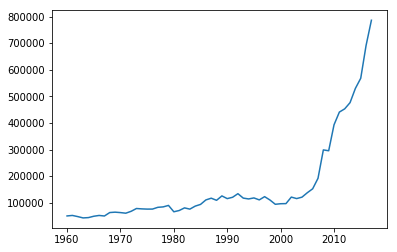

In [284]:
plt.plot(tx_energy.Years,tx_Renewable.Renewable_en_prod)

In [285]:
scaler_tx_Renewable  = MinMaxScaler(feature_range=(0, 1))
tx_Renewable = scaler_tx_Renewable.fit_transform(tx_Renewable)

# split into train and test sets
train_size_tx_Renewable  = int(len(tx_Renewable) * 0.67)
test_size_tx_Renewable  = len(tx_Renewable) - train_size_tx_Renewable 
train_tx_Renewable , test_tx_Renewable  = tx_Renewable [0:train_size_tx_Renewable,:], tx_Renewable [train_size_tx_Renewable :len(tx_Renewable),:]

# convert an array of values into a dataset matrix
def create_tx_Renewable(tx_Renewable, look_back=1):
	dataX_tx_Renewable, dataY_tx_Renewable = [], []
	for i_tx_Renewable in range(len(tx_Renewable)-look_back-1):
		a_tx_Renewable = tx_Renewable[i_tx_Renewable:(i_tx_Renewable+look_back), 0]
		dataX_tx_Renewable.append(a_tx_Renewable)
		dataY_tx_Renewable.append(tx_Renewable[i_tx_Renewable + look_back, 0])
	return numpy.array(dataX_tx_Renewable), numpy.array(dataY_tx_Renewable)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_Renewable, trainY_tx_Renewable = create_tx_Renewable(train_tx_Renewable, look_back)
testX_tx_Renewable, testY_tx_Renewable = create_tx_Renewable(test_tx_Renewable, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_Renewable = numpy.reshape(trainX_tx_Renewable, (trainX_tx_Renewable.shape[0], 1, trainX_tx_Renewable.shape[1]))
testX_tx_Renewable = numpy.reshape(testX_tx_Renewable, (testX_tx_Renewable.shape[0], 1, testX_tx_Renewable.shape[1]))

# create and fit the LSTM network
model_tx_Renewable = Sequential()
model_tx_Renewable.add(LSTM(4, input_shape=(1, look_back)))
model_tx_Renewable.add(Dense(1))
model_tx_Renewable.compile(loss='mean_squared_error', optimizer='adam')
model_tx_Renewable.fit(trainX_tx_Renewable, trainY_tx_Renewable, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.0037
Epoch 2/100
 - 0s - loss: 0.0018
Epoch 3/100
 - 0s - loss: 0.0016
Epoch 4/100
 - 0s - loss: 0.0015
Epoch 5/100
 - 0s - loss: 0.0015
Epoch 6/100
 - 0s - loss: 0.0015
Epoch 7/100
 - 0s - loss: 0.0014
Epoch 8/100
 - 0s - loss: 0.0014
Epoch 9/100
 - 0s - loss: 0.0014
Epoch 10/100
 - 0s - loss: 0.0014
Epoch 11/100
 - 0s - loss: 0.0013
Epoch 12/100
 - 0s - loss: 0.0013
Epoch 13/100
 - 0s - loss: 0.0013
Epoch 14/100
 - 0s - loss: 0.0013
Epoch 15/100
 - 0s - loss: 0.0012
Epoch 16/100
 - 0s - loss: 0.0012
Epoch 17/100
 - 0s - loss: 0.0012
Epoch 18/100
 - 0s - loss: 0.0012
Epoch 19/100
 - 0s - loss: 0.0012
Epoch 20/100
 - 0s - loss: 0.0012
Epoch 21/100
 - 0s - loss: 0.0011
Epoch 22/100
 - 0s - loss: 0.0011
Epoch 23/100
 - 0s - loss: 0.0011
Epoch 24/100
 - 0s - loss: 0.0011
Epoch 25/100
 - 0s - loss: 0.0010
Epoch 26/100
 - 0s - loss: 9.9709e-04
Epoch 27/100
 - 0s - loss: 9.8032e-04
Epoch 28/100
 - 0s - loss: 9.5880e-04
Epoch 29/100
 - 0s - loss: 9.1508e-04
Epoch 3

In [286]:
# make predictions
trainPredict_tx_Renewable = model_tx_Renewable.predict(trainX_tx_Renewable)
testPredict_tx_Renewable = model_tx_Renewable.predict(testX_tx_Renewable)
# invert predictions
trainPredict_tx_Renewable = scaler_tx_Renewable.inverse_transform(trainPredict_tx_Renewable)
trainY_tx_Renewable = scaler_tx_Renewable.inverse_transform([trainY_tx_Renewable])
testPredict_tx_Renewable = scaler_tx_Renewable.inverse_transform(testPredict_tx_Renewable)
testY_tx_Renewable = scaler_tx_Renewable.inverse_transform([testY_tx_Renewable])
# calculate root mean squared error
trainScore_tx_Renewable = math.sqrt(mean_squared_error(trainY_tx_Renewable[0], trainPredict_tx_Renewable[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_Renewable))
testScore_tx_Renewable = math.sqrt(mean_squared_error(testY_tx_Renewable[0], testPredict_tx_Renewable[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_Renewable))

Train Score: 9140.88 RMSE
Test Score: 62821.66 RMSE


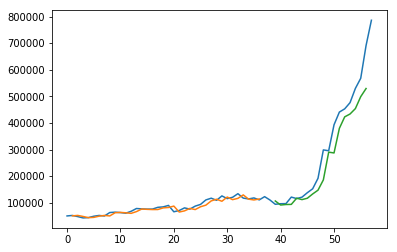

In [287]:
# shift train predictions for plotting
trainPredictPlot_tx_Renewable = numpy.empty_like(tx_Renewable)
trainPredictPlot_tx_Renewable[:, :] = numpy.nan
trainPredictPlot_tx_Renewable[look_back:len(trainPredict_tx_Renewable)+look_back, :] = trainPredict_tx_Renewable
# shift test predictions for plotting
testPredictPlot_tx_Renewable = numpy.empty_like(tx_Renewable)
testPredictPlot_tx_Renewable[:, :] = numpy.nan
testPredictPlot_tx_Renewable[len(trainPredict_tx_Renewable)+(look_back*2)+1:len(tx_Renewable)-1, :] = testPredict_tx_Renewable
# plot baseline and predictions
plt.plot(scaler_tx_Renewable.inverse_transform(tx_Renewable))
plt.plot(trainPredictPlot_tx_Renewable)
plt.plot(testPredictPlot_tx_Renewable)
plt.show()

In [288]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_Renewable, trainY_tx_Renewable = create_tx_Renewable(tx_Renewable, look_back)
trainX_tx_Renewable = numpy.reshape(trainX_tx_Renewable, (trainX_tx_Renewable.shape[0], 1, trainX_tx_Renewable.shape[1]))

# re-create and fit the LSTM network
model_tx_Renewable = Sequential()
model_tx_Renewable.add(LSTM(4, input_shape=(1, look_back)))
model_tx_Renewable.add(Dense(1))
model_tx_Renewable.compile(loss='mean_squared_error', optimizer='adam')
model_tx_Renewable.fit(trainX_tx_Renewable, trainY_tx_Renewable, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 6s - loss: 0.1274
Epoch 2/100
 - 0s - loss: 0.0947
Epoch 3/100
 - 0s - loss: 0.0724
Epoch 4/100
 - 0s - loss: 0.0604
Epoch 5/100
 - 0s - loss: 0.0486
Epoch 6/100
 - 0s - loss: 0.0435
Epoch 7/100
 - 0s - loss: 0.0381
Epoch 8/100
 - 0s - loss: 0.0349
Epoch 9/100
 - 0s - loss: 0.0322
Epoch 10/100
 - 0s - loss: 0.0297
Epoch 11/100
 - 0s - loss: 0.0279
Epoch 12/100
 - 0s - loss: 0.0256
Epoch 13/100
 - 0s - loss: 0.0234
Epoch 14/100
 - 0s - loss: 0.0215
Epoch 15/100
 - 0s - loss: 0.0195
Epoch 16/100
 - 0s - loss: 0.0180
Epoch 17/100
 - 0s - loss: 0.0159
Epoch 18/100
 - 0s - loss: 0.0151
Epoch 19/100
 - 0s - loss: 0.0133
Epoch 20/100
 - 0s - loss: 0.0115
Epoch 21/100
 - 0s - loss: 0.0105
Epoch 22/100
 - 0s - loss: 0.0097
Epoch 23/100
 - 0s - loss: 0.0085
Epoch 24/100
 - 0s - loss: 0.0075
Epoch 25/100
 - 0s - loss: 0.0071
Epoch 26/100
 - 0s - loss: 0.0061
Epoch 27/100
 - 0s - loss: 0.0057
Epoch 28/100
 - 0s - loss: 0.0052
Epoch 29/100
 - 0s - loss: 0.0049
Epoch 30/100
 - 0s - lo

Epoch 1/100
 - 5s - loss: 0.1020
Epoch 2/100
 - 0s - loss: 0.0773
Epoch 3/100
 - 0s - loss: 0.0599
Epoch 4/100
 - 0s - loss: 0.0478
Epoch 5/100
 - 0s - loss: 0.0395
Epoch 6/100
 - 0s - loss: 0.0348
Epoch 7/100
 - 0s - loss: 0.0306
Epoch 8/100
 - 0s - loss: 0.0279
Epoch 9/100
 - 0s - loss: 0.0257
Epoch 10/100
 - 0s - loss: 0.0237
Epoch 11/100
 - 0s - loss: 0.0217
Epoch 12/100
 - 0s - loss: 0.0198
Epoch 13/100
 - 0s - loss: 0.0180
Epoch 14/100
 - 0s - loss: 0.0164
Epoch 15/100
 - 0s - loss: 0.0149
Epoch 16/100
 - 0s - loss: 0.0132
Epoch 17/100
 - 0s - loss: 0.0118
Epoch 18/100
 - 0s - loss: 0.0105
Epoch 19/100
 - 0s - loss: 0.0095
Epoch 20/100
 - 0s - loss: 0.0085
Epoch 21/100
 - 0s - loss: 0.0074
Epoch 22/100
 - 0s - loss: 0.0067
Epoch 23/100
 - 0s - loss: 0.0060
Epoch 24/100
 - 0s - loss: 0.0054
Epoch 25/100
 - 0s - loss: 0.0047
Epoch 26/100
 - 0s - loss: 0.0044
Epoch 27/100
 - 0s - loss: 0.0041
Epoch 28/100
 - 0s - loss: 0.0037
Epoch 29/100
 - 0s - loss: 0.0035
Epoch 30/100
 - 0s - lo

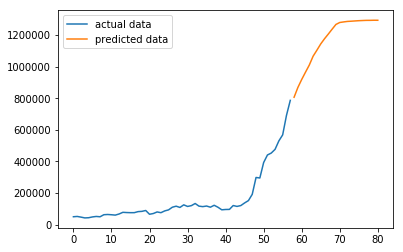

In [289]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_Renewable, trainY_tx_Renewable = create_tx_Renewable(tx_Renewable, look_back)
trainX_tx_Renewable = numpy.reshape(trainX_tx_Renewable, (trainX_tx_Renewable.shape[0], 1, trainX_tx_Renewable.shape[1]))

# re-create and fit the LSTM network
model_tx_Renewable = Sequential()
model_tx_Renewable.add(LSTM(4, input_shape=(1, look_back)))
model_tx_Renewable.add(Dense(1))
model_tx_Renewable.compile(loss='mean_squared_error', optimizer='adam')
model_tx_Renewable.fit(trainX_tx_Renewable, trainY_tx_Renewable, epochs=100, batch_size=1, verbose=2)


# making future prediction
flatten_tx_Renewable = tx_Renewable.reshape(-1)
val_tx_Renewable = flatten_tx_Renewable[-look_back:] # last batch in the training data
pred_list_tx_Renewable = []
for i_tx_Renewable in range(23): # predict the next 23 points
    pred_tx_Renewable = model_tx_Renewable.predict(val_tx_Renewable.reshape(1,1,look_back))
    pred_list_tx_Renewable = np.append(pred_list_tx_Renewable,pred_tx_Renewable)
    val_tx_Renewable = np.append(np.delete(val_tx_Renewable, 0),pred_tx_Renewable) # update the data batch to be fed in the next iteration
pred_list_tx_Renewable = pred_list_tx_Renewable.reshape(pred_list_tx_Renewable.shape[0],1)

# invert prediction
pred_list_tx_Renewable = scaler_tx_Renewable.inverse_transform(pred_list_tx_Renewable)

# plot
tx_Renewable_len = len(tx_Renewable)
print(tx_oil_len)
plt.plot(list(range(tx_Renewable_len)),scaler_tx_Renewable.inverse_transform(tx_Renewable),label="actual data")
plt.plot(list(range(tx_Renewable_len,tx_Renewable_len+len(pred_list_tx_Renewable))),pred_list_tx_Renewable,label="predicted data")
plt.legend()
plt.show()

texas renewable energy production 1965-2040

In [290]:
L_Renewable = pred_list_tx_Renewable
tx_Renewable_pre = pd.DataFrame(L, columns=["Renewable_en_prod"])
# tx_Renewable_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
Renewable_pred = pd.concat([pre_yrs, tx_Renewable_pre], axis=1, sort=False)
Renewable_pred.head()
tx_Renewable = tx_energy[["Years", "Renewable_en_prod"]]
tx_Renewable.head()
TexasRenewable_prod_pre = pd.concat([tx_Renewable, Renewable_pred])
TexasRenewable_prod_pre.head()

,Years,Renewable_en_prod
0,1960,50155.0
1,1961,52023.0
2,1962,47721.0
3,1963,42718.0
4,1964,43884.0


# Texas Total Energy production Forcasting model 

In [291]:
tx_TotalEnergy= tx_energy[["Total_en_prod"]]
tx_TotalEnergy.head()

,Total_en_prod
0,12058639.0
1,12208006.0
2,12357635.0
3,12693749.0
4,13123816.0


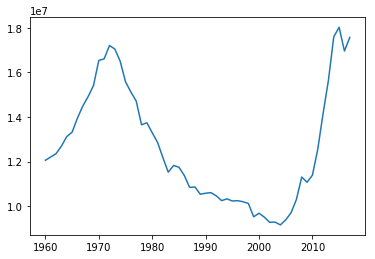

In [292]:
tx_TotalEnergy= tx_energy[["Total_en_prod"]]
tx_TotalEnergy.head()
plt.plot(tx_energy.Years,tx_TotalEnergy.Total_en_prod)

In [293]:
scaler_tx_TotalEnergy  = MinMaxScaler(feature_range=(0, 1))
tx_TotalEnergy = scaler_tx_TotalEnergy.fit_transform(tx_TotalEnergy)

# split into train and test sets
train_size_tx_TotalEnergy  = int(len(tx_TotalEnergy) * 0.67)
test_size_tx_TotalEnergy  = len(tx_TotalEnergy) - train_size_tx_TotalEnergy 
train_tx_TotalEnergy , test_tx_TotalEnergy  = tx_TotalEnergy [0:train_size_tx_TotalEnergy,:], tx_TotalEnergy [train_size_tx_TotalEnergy :len(tx_TotalEnergy),:]

# convert an array of values into a dataset matrix
def create_tx_TotalEnergy(tx_TotalEnergy, look_back=1):
	dataX_tx_TotalEnergy, dataY_tx_TotalEnergy = [], []
	for i_tx_TotalEnergy in range(len(tx_TotalEnergy)-look_back-1):
		a_tx_TotalEnergy = tx_TotalEnergy[i_tx_TotalEnergy:(i_tx_TotalEnergy+look_back), 0]
		dataX_tx_TotalEnergy.append(a_tx_TotalEnergy)
		dataY_tx_TotalEnergy.append(tx_TotalEnergy[i_tx_TotalEnergy + look_back, 0])
	return numpy.array(dataX_tx_TotalEnergy), numpy.array(dataY_tx_TotalEnergy)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_TotalEnergy, trainY_tx_TotalEnergy = create_tx_TotalEnergy(train_tx_TotalEnergy, look_back)
testX_tx_TotalEnergy, testY_tx_TotalEnergy = create_tx_TotalEnergy(test_tx_TotalEnergy, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_TotalEnergy = numpy.reshape(trainX_tx_TotalEnergy, (trainX_tx_TotalEnergy.shape[0], 1, trainX_tx_TotalEnergy.shape[1]))
testX_tx_TotalEnergy = numpy.reshape(testX_tx_TotalEnergy, (testX_tx_TotalEnergy.shape[0], 1, testX_tx_TotalEnergy.shape[1]))

# create and fit the LSTM network
model_tx_TotalEnergy = Sequential()
model_tx_TotalEnergy.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy.add(Dense(1))
model_tx_TotalEnergy.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy.fit(trainX_tx_TotalEnergy, trainY_tx_TotalEnergy, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.2698
Epoch 2/100
 - 0s - loss: 0.2191
Epoch 3/100
 - 0s - loss: 0.1787
Epoch 4/100
 - 0s - loss: 0.1475
Epoch 5/100
 - 0s - loss: 0.1223
Epoch 6/100
 - 0s - loss: 0.1017
Epoch 7/100
 - 0s - loss: 0.0869
Epoch 8/100
 - 0s - loss: 0.0749
Epoch 9/100
 - 0s - loss: 0.0663
Epoch 10/100
 - 0s - loss: 0.0596
Epoch 11/100
 - 0s - loss: 0.0549
Epoch 12/100
 - 0s - loss: 0.0514
Epoch 13/100
 - 0s - loss: 0.0487
Epoch 14/100
 - 0s - loss: 0.0474
Epoch 15/100
 - 0s - loss: 0.0455
Epoch 16/100
 - 0s - loss: 0.0438
Epoch 17/100
 - 0s - loss: 0.0429
Epoch 18/100
 - 0s - loss: 0.0421
Epoch 19/100
 - 0s - loss: 0.0409
Epoch 20/100
 - 0s - loss: 0.0401
Epoch 21/100
 - 0s - loss: 0.0387
Epoch 22/100
 - 0s - loss: 0.0380
Epoch 23/100
 - 0s - loss: 0.0371
Epoch 24/100
 - 0s - loss: 0.0359
Epoch 25/100
 - 0s - loss: 0.0353
Epoch 26/100
 - 0s - loss: 0.0340
Epoch 27/100
 - 0s - loss: 0.0331
Epoch 28/100
 - 0s - loss: 0.0323
Epoch 29/100
 - 0s - loss: 0.0311
Epoch 30/100
 - 0s - lo

Train Score: 466169.55 RMSE
Test Score: 890690.70 RMSE


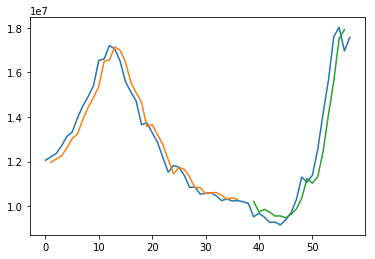

In [294]:
# make predictions
trainPredict_tx_TotalEnergy = model_tx_TotalEnergy.predict(trainX_tx_TotalEnergy)
testPredict_tx_TotalEnergy = model_tx_TotalEnergy.predict(testX_tx_TotalEnergy)
# invert predictions
trainPredict_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform(trainPredict_tx_TotalEnergy)
trainY_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform([trainY_tx_TotalEnergy])
testPredict_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform(testPredict_tx_TotalEnergy)
testY_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform([testY_tx_TotalEnergy])
# calculate root mean squared error
trainScore_tx_TotalEnergy = math.sqrt(mean_squared_error(trainY_tx_TotalEnergy[0], trainPredict_tx_TotalEnergy[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_TotalEnergy))
testScore_tx_TotalEnergy = math.sqrt(mean_squared_error(testY_tx_TotalEnergy[0], testPredict_tx_TotalEnergy[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_TotalEnergy))

# shift train predictions for plotting
trainPredictPlot_tx_TotalEnergy = numpy.empty_like(tx_TotalEnergy)
trainPredictPlot_tx_TotalEnergy[:, :] = numpy.nan
trainPredictPlot_tx_TotalEnergy[look_back:len(trainPredict_tx_TotalEnergy)+look_back, :] = trainPredict_tx_TotalEnergy
# shift test predictions for plotting
testPredictPlot_tx_TotalEnergy = numpy.empty_like(tx_TotalEnergy)
testPredictPlot_tx_TotalEnergy[:, :] = numpy.nan
testPredictPlot_tx_TotalEnergy[len(trainPredict_tx_TotalEnergy)+(look_back*2)+1:len(tx_TotalEnergy)-1, :] = testPredict_tx_TotalEnergy
# plot baseline and predictions
plt.plot(scaler_tx_TotalEnergy.inverse_transform(tx_TotalEnergy))
plt.plot(trainPredictPlot_tx_TotalEnergy)
plt.plot(testPredictPlot_tx_TotalEnergy)
plt.show()

Epoch 1/100
 - 5s - loss: 0.1272
Epoch 2/100
 - 0s - loss: 0.1056
Epoch 3/100
 - 0s - loss: 0.0964
Epoch 4/100
 - 0s - loss: 0.0877
Epoch 5/100
 - 0s - loss: 0.0778
Epoch 6/100
 - 0s - loss: 0.0686
Epoch 7/100
 - 0s - loss: 0.0606
Epoch 8/100
 - 0s - loss: 0.0513
Epoch 9/100
 - 0s - loss: 0.0436
Epoch 10/100
 - 0s - loss: 0.0371
Epoch 11/100
 - 0s - loss: 0.0296
Epoch 12/100
 - 0s - loss: 0.0242
Epoch 13/100
 - 0s - loss: 0.0202
Epoch 14/100
 - 0s - loss: 0.0157
Epoch 15/100
 - 0s - loss: 0.0133
Epoch 16/100
 - 0s - loss: 0.0111
Epoch 17/100
 - 0s - loss: 0.0095
Epoch 18/100
 - 0s - loss: 0.0082
Epoch 19/100
 - 0s - loss: 0.0074
Epoch 20/100
 - 0s - loss: 0.0072
Epoch 21/100
 - 0s - loss: 0.0062
Epoch 22/100
 - 0s - loss: 0.0057
Epoch 23/100
 - 0s - loss: 0.0053
Epoch 24/100
 - 0s - loss: 0.0051
Epoch 25/100
 - 0s - loss: 0.0050
Epoch 26/100
 - 0s - loss: 0.0050
Epoch 27/100
 - 0s - loss: 0.0046
Epoch 28/100
 - 0s - loss: 0.0047
Epoch 29/100
 - 0s - loss: 0.0045
Epoch 30/100
 - 0s - lo

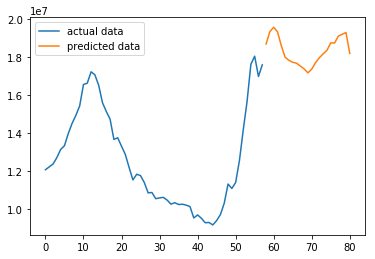

In [295]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_TotalEnergy, trainY_tx_TotalEnergy = create_tx_TotalEnergy(tx_TotalEnergy, look_back)
trainX_tx_TotalEnergy = numpy.reshape(trainX_tx_TotalEnergy, (trainX_tx_TotalEnergy.shape[0], 1, trainX_tx_TotalEnergy.shape[1]))

# re-create and fit the LSTM network
model_tx_TotalEnergy = Sequential()
model_tx_TotalEnergy.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy.add(Dense(1))
model_tx_TotalEnergy.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy.fit(trainX_tx_TotalEnergy, trainY_tx_TotalEnergy, epochs=100, batch_size=1, verbose=2)


# making future prediction
flatten_tx_TotalEnergy = tx_TotalEnergy.reshape(-1)
val_tx_TotalEnergy = flatten_tx_TotalEnergy[-look_back:] # last batch in the training data
pred_list_tx_TotalEnergy = []
for i_tx_TotalEnergy in range(23): # predict the next 23 points
    pred_tx_TotalEnergy = model_tx_TotalEnergy.predict(val_tx_TotalEnergy.reshape(1,1,look_back))
    pred_list_tx_TotalEnergy = np.append(pred_list_tx_TotalEnergy,pred_tx_TotalEnergy)
    val_tx_TotalEnergy = np.append(np.delete(val_tx_TotalEnergy, 0),pred_tx_TotalEnergy) # update the data batch to be fed in the next iteration
pred_list_tx_TotalEnergy = pred_list_tx_TotalEnergy.reshape(pred_list_tx_TotalEnergy.shape[0],1)

# invert prediction
pred_list_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform(pred_list_tx_TotalEnergy)

# plot
tx_TotalEnergy_len = len(tx_TotalEnergy)
print(tx_oil_len)
plt.plot(list(range(tx_TotalEnergy_len)),scaler_tx_TotalEnergy.inverse_transform(tx_TotalEnergy),label="actual data")
plt.plot(list(range(tx_TotalEnergy_len,tx_TotalEnergy_len+len(pred_list_tx_TotalEnergy))),pred_list_tx_TotalEnergy,label="predicted data")
plt.legend()
plt.show()

texas renewable energy production 1965-2040

In [296]:
L_TotalEnergy = pred_list_tx_TotalEnergy
tx_TotalEnergy_pre = pd.DataFrame(L, columns=["Total_en_prod"])
# tx_TotalEnergy_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
TotalEnergy_pred = pd.concat([pre_yrs, tx_TotalEnergy_pre], axis=1, sort=False)
TotalEnergy_pred.head()
tx_TotalEnergy = tx_energy[["Years", "Total_en_prod"]]
tx_TotalEnergy.head()
TexasTotalEnergy_prod_pre = pd.concat([tx_TotalEnergy, TotalEnergy_pred])
TexasTotalEnergy_prod_pre.head()

,Years,Total_en_prod
0,1960,12058639.0
1,1961,12208006.0
2,1962,12357635.0
3,1963,12693749.0
4,1964,13123816.0


# Texas Total energy consumption forcast model 

In [297]:
tx_TotalEnergy_consumption= tx_energy[["Total_en_consumption"]]
tx_TotalEnergy_consumption.head()


,Total_en_consumption
0,4416216.0
1,4447880.0
2,4640675.0
3,4894089.0
4,5012683.0


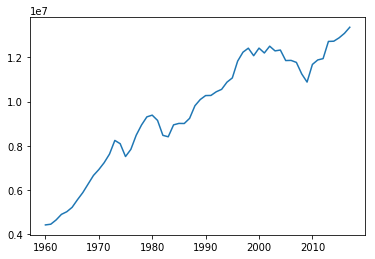

In [298]:
tx_TotalEnergy_consumption= tx_energy[["Total_en_consumption"]]
tx_TotalEnergy_consumption.head()
plt.plot(tx_energy.Years,tx_TotalEnergy_consumption.Total_en_consumption)

In [299]:
scaler_tx_TotalEnergy_consumption  = MinMaxScaler(feature_range=(0, 1))
tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.fit_transform(tx_TotalEnergy_consumption)

# split into train and test sets
train_size_tx_TotalEnergy_consumption  = int(len(tx_TotalEnergy_consumption) * 0.67)
test_size_tx_TotalEnergy_consumption  = len(tx_TotalEnergy_consumption) - train_size_tx_TotalEnergy_consumption 
train_tx_TotalEnergy_consumption , test_tx_TotalEnergy_consumption  = tx_TotalEnergy_consumption [0:train_size_tx_TotalEnergy_consumption,:], tx_TotalEnergy_consumption [train_size_tx_TotalEnergy_consumption :len(tx_TotalEnergy_consumption),:]

# convert an array of values into a dataset matrix
def create_tx_TotalEnergy_consumption(tx_TotalEnergy_consumption, look_back=1):
	dataX_tx_TotalEnergy_consumption, dataY_tx_TotalEnergy_consumption = [], []
	for i_tx_TotalEnergy_consumption in range(len(tx_TotalEnergy_consumption)-look_back-1):
		a_tx_TotalEnergy_consumption = tx_TotalEnergy_consumption[i_tx_TotalEnergy_consumption:(i_tx_TotalEnergy_consumption+look_back), 0]
		dataX_tx_TotalEnergy_consumption.append(a_tx_TotalEnergy_consumption)
		dataY_tx_TotalEnergy_consumption.append(tx_TotalEnergy_consumption[i_tx_TotalEnergy_consumption + look_back, 0])
	return numpy.array(dataX_tx_TotalEnergy_consumption), numpy.array(dataY_tx_TotalEnergy_consumption)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_TotalEnergy_consumption, trainY_tx_TotalEnergy_consumption = create_tx_TotalEnergy_consumption(train_tx_TotalEnergy_consumption, look_back)
testX_tx_TotalEnergy_consumption, testY_tx_TotalEnergy_consumption = create_tx_TotalEnergy_consumption(test_tx_TotalEnergy_consumption, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_TotalEnergy_consumption = numpy.reshape(trainX_tx_TotalEnergy_consumption, (trainX_tx_TotalEnergy_consumption.shape[0], 1, trainX_tx_TotalEnergy_consumption.shape[1]))
testX_tx_TotalEnergy_consumption = numpy.reshape(testX_tx_TotalEnergy_consumption, (testX_tx_TotalEnergy_consumption.shape[0], 1, testX_tx_TotalEnergy_consumption.shape[1]))

# create and fit the LSTM network
model_tx_TotalEnergy_consumption = Sequential()
model_tx_TotalEnergy_consumption.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy_consumption.add(Dense(1))
model_tx_TotalEnergy_consumption.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy_consumption.fit(trainX_tx_TotalEnergy_consumption, trainY_tx_TotalEnergy_consumption, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 7s - loss: 0.2529
Epoch 2/100
 - 0s - loss: 0.2016
Epoch 3/100
 - 0s - loss: 0.1613
Epoch 4/100
 - 0s - loss: 0.1278
Epoch 5/100
 - 0s - loss: 0.1021
Epoch 6/100
 - 0s - loss: 0.0811
Epoch 7/100
 - 0s - loss: 0.0649
Epoch 8/100
 - 0s - loss: 0.0537
Epoch 9/100
 - 0s - loss: 0.0463
Epoch 10/100
 - 0s - loss: 0.0400
Epoch 11/100
 - 0s - loss: 0.0366
Epoch 12/100
 - 0s - loss: 0.0341
Epoch 13/100
 - 0s - loss: 0.0323
Epoch 14/100
 - 0s - loss: 0.0310
Epoch 15/100
 - 0s - loss: 0.0297
Epoch 16/100
 - 0s - loss: 0.0286
Epoch 17/100
 - 0s - loss: 0.0275
Epoch 18/100
 - 0s - loss: 0.0266
Epoch 19/100
 - 0s - loss: 0.0254
Epoch 20/100
 - 0s - loss: 0.0244
Epoch 21/100
 - 0s - loss: 0.0234
Epoch 22/100
 - 0s - loss: 0.0224
Epoch 23/100
 - 0s - loss: 0.0214
Epoch 24/100
 - 0s - loss: 0.0202
Epoch 25/100
 - 0s - loss: 0.0191
Epoch 26/100
 - 0s - loss: 0.0181
Epoch 27/100
 - 0s - loss: 0.0171
Epoch 28/100
 - 0s - loss: 0.0161
Epoch 29/100
 - 0s - loss: 0.0151
Epoch 30/100
 - 0s - lo

Train Score: 314138.97 RMSE
Test Score: 363348.63 RMSE


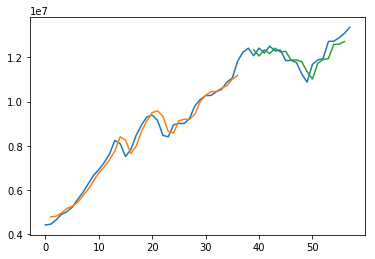

In [300]:
# make predictions
trainPredict_tx_TotalEnergy_consumption = model_tx_TotalEnergy_consumption.predict(trainX_tx_TotalEnergy_consumption)
testPredict_tx_TotalEnergy_consumption = model_tx_TotalEnergy_consumption.predict(testX_tx_TotalEnergy_consumption)
# invert predictions
trainPredict_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform(trainPredict_tx_TotalEnergy_consumption)
trainY_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform([trainY_tx_TotalEnergy_consumption])
testPredict_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform(testPredict_tx_TotalEnergy_consumption)
testY_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform([testY_tx_TotalEnergy_consumption])
# calculate root mean squared error
trainScore_tx_TotalEnergy_consumption = math.sqrt(mean_squared_error(trainY_tx_TotalEnergy_consumption[0], trainPredict_tx_TotalEnergy_consumption[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_TotalEnergy_consumption))
testScore_tx_TotalEnergy_consumption = math.sqrt(mean_squared_error(testY_tx_TotalEnergy_consumption[0], testPredict_tx_TotalEnergy_consumption[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_TotalEnergy_consumption))

# shift train predictions for plotting
trainPredictPlot_tx_TotalEnergy_consumption = numpy.empty_like(tx_TotalEnergy_consumption)
trainPredictPlot_tx_TotalEnergy_consumption[:, :] = numpy.nan
trainPredictPlot_tx_TotalEnergy_consumption[look_back:len(trainPredict_tx_TotalEnergy_consumption)+look_back, :] = trainPredict_tx_TotalEnergy_consumption
# shift test predictions for plotting
testPredictPlot_tx_TotalEnergy_consumption = numpy.empty_like(tx_TotalEnergy_consumption)
testPredictPlot_tx_TotalEnergy_consumption[:, :] = numpy.nan
testPredictPlot_tx_TotalEnergy_consumption[len(trainPredict_tx_TotalEnergy_consumption)+(look_back*2)+1:len(tx_TotalEnergy_consumption)-1, :] = testPredict_tx_TotalEnergy_consumption
# plot baseline and predictions
plt.plot(scaler_tx_TotalEnergy_consumption.inverse_transform(tx_TotalEnergy_consumption))
plt.plot(trainPredictPlot_tx_TotalEnergy_consumption)
plt.plot(testPredictPlot_tx_TotalEnergy_consumption)
plt.show()

Epoch 1/100
 - 6s - loss: 0.6118
Epoch 2/100
 - 0s - loss: 0.3559
Epoch 3/100
 - 0s - loss: 0.1771
Epoch 4/100
 - 0s - loss: 0.0611
Epoch 5/100
 - 0s - loss: 0.0131
Epoch 6/100
 - 0s - loss: 0.0051
Epoch 7/100
 - 0s - loss: 0.0052
Epoch 8/100
 - 0s - loss: 0.0049
Epoch 9/100
 - 0s - loss: 0.0048
Epoch 10/100
 - 0s - loss: 0.0045
Epoch 11/100
 - 0s - loss: 0.0044
Epoch 12/100
 - 0s - loss: 0.0042
Epoch 13/100
 - 0s - loss: 0.0041
Epoch 14/100
 - 0s - loss: 0.0043
Epoch 15/100
 - 0s - loss: 0.0043
Epoch 16/100
 - 0s - loss: 0.0040
Epoch 17/100
 - 0s - loss: 0.0040
Epoch 18/100
 - 0s - loss: 0.0039
Epoch 19/100
 - 0s - loss: 0.0038
Epoch 20/100
 - 0s - loss: 0.0039
Epoch 21/100
 - 0s - loss: 0.0037
Epoch 22/100
 - 0s - loss: 0.0038
Epoch 23/100
 - 0s - loss: 0.0037
Epoch 24/100
 - 0s - loss: 0.0038
Epoch 25/100
 - 0s - loss: 0.0038
Epoch 26/100
 - 0s - loss: 0.0038
Epoch 27/100
 - 0s - loss: 0.0035
Epoch 28/100
 - 0s - loss: 0.0036
Epoch 29/100
 - 0s - loss: 0.0035
Epoch 30/100
 - 0s - lo

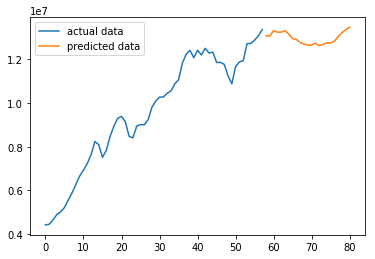

In [301]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_TotalEnergy_consumption, trainY_tx_TotalEnergy_consumption = create_tx_TotalEnergy_consumption(tx_TotalEnergy_consumption, look_back)
trainX_tx_TotalEnergy_consumption = numpy.reshape(trainX_tx_TotalEnergy_consumption, (trainX_tx_TotalEnergy_consumption.shape[0], 1, trainX_tx_TotalEnergy_consumption.shape[1]))

# re-create and fit the LSTM network
model_tx_TotalEnergy_consumption = Sequential()
model_tx_TotalEnergy_consumption.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy_consumption.add(Dense(1))
model_tx_TotalEnergy_consumption.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy_consumption.fit(trainX_tx_TotalEnergy_consumption, trainY_tx_TotalEnergy_consumption, epochs=100, batch_size=1, verbose=2)


# making future prediction
flatten_tx_TotalEnergy_consumption = tx_TotalEnergy_consumption.reshape(-1)
val_tx_TotalEnergy_consumption = flatten_tx_TotalEnergy_consumption[-look_back:] # last batch in the training data
pred_list_tx_TotalEnergy_consumption = []
for i_tx_TotalEnergy_consumption in range(23): # predict the next 23 points
    pred_tx_TotalEnergy_consumption = model_tx_TotalEnergy_consumption.predict(val_tx_TotalEnergy_consumption.reshape(1,1,look_back))
    pred_list_tx_TotalEnergy_consumption = np.append(pred_list_tx_TotalEnergy_consumption,pred_tx_TotalEnergy_consumption)
    val_tx_TotalEnergy_consumption = np.append(np.delete(val_tx_TotalEnergy_consumption, 0),pred_tx_TotalEnergy_consumption) # update the data batch to be fed in the next iteration
pred_list_tx_TotalEnergy_consumption = pred_list_tx_TotalEnergy_consumption.reshape(pred_list_tx_TotalEnergy_consumption.shape[0],1)

# invert prediction
pred_list_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform(pred_list_tx_TotalEnergy_consumption)

# plot
tx_TotalEnergy_consumption_len = len(tx_TotalEnergy_consumption)
print(tx_oil_len)
plt.plot(list(range(tx_TotalEnergy_consumption_len)),scaler_tx_TotalEnergy_consumption.inverse_transform(tx_TotalEnergy_consumption),label="actual data")
plt.plot(list(range(tx_TotalEnergy_consumption_len,tx_TotalEnergy_consumption_len+len(pred_list_tx_TotalEnergy_consumption))),pred_list_tx_TotalEnergy_consumption,label="predicted data")
plt.legend()
plt.show()

texas renewable energy production 1965-2040

In [306]:
L_TotalEnergy_consumption = pred_list_tx_TotalEnergy_consumption
tx_TotalEnergy_consumption_pre = pd.DataFrame(L, columns=["Total_en_consumption"])

TotalEnergy_consumption_pred = pd.concat([pre_yrs, tx_TotalEnergy_consumption_pre], axis=1, sort=False)
TotalEnergy_consumption_pred.head()
tx_TotalEnergy_consumption = tx_energy[["Years", "Total_en_consumption"]]
tx_TotalEnergy_consumption.head()
TexasTotalEnergy_consumption_prod_pre = pd.concat([tx_TotalEnergy_consumption, TotalEnergy_consumption_pred])
TexasTotalEnergy_consumption_prod_pre.head()


,Years,Total_en_consumption
0,1960,4416216.0
1,1961,4447880.0
2,1962,4640675.0
3,1963,4894089.0
4,1964,5012683.0


# merge all productions/predictions into one dataframe 

In [307]:
from functools import reduce
dfs = [TexasCoal_prod_pre, TexasOil_prod_pre, Texasgas_prod_pre, TexasRenewable_prod_pre, TexasTotalEnergy_prod_pre, TexasTotalEnergy_consumption_prod_pre]

TexasEnergy = reduce(lambda left,right: pd.merge(left,right,on='Years'), dfs)
TexasEnergy

,Years,Coal_prod,Oil_prod,Gas_prod,Renewable_en_prod,Total_en_prod,Total_en_consumption
0,1960,26409.000000,5.379378e+06,6.602696e+06,50155.000000,1.205864e+07,4.416216e+06
1,1961,26535.000000,5.447308e+06,6.682140e+06,52023.000000,1.220801e+07,4.447880e+06
2,1962,25855.000000,5.471272e+06,6.812787e+06,47721.000000,1.235764e+07,4.640675e+06
3,1963,27441.000000,5.671135e+06,6.952455e+06,42718.000000,1.269375e+07,4.894089e+06
4,1964,28839.000000,5.739216e+06,7.311876e+06,43884.000000,1.312382e+07,5.012683e+06
5,1965,30349.000000,5.804308e+06,7.436127e+06,48967.000000,1.331975e+07,5.212184e+06
6,1966,28360.000000,6.127692e+06,7.746648e+06,51980.000000,1.395468e+07,5.557255e+06
7,1967,27102.000000,6.480449e+06,7.934585e+06,49944.000000,1.449208e+07,5.879030e+06
8,1968,28839.000000,6.555601e+06,8.271293e+06,62939.000000,1.491867e+07,6.268911e+06
9,1969,28310.000000,6.664147e+06,8.654795e+06,64351.000000,1.541160e+07,6.656323e+06


In [308]:

np.round(TexasEnergy, decimals=2)

,Years,Coal_prod,Oil_prod,Gas_prod,Renewable_en_prod,Total_en_prod,Total_en_consumption
0,1960,26409.00,5379378.00,6602696.00,50155.00,12058639.00,4416216.00
1,1961,26535.00,5447308.00,6682140.00,52023.00,12208006.00,4447880.00
2,1962,25855.00,5471272.00,6812787.00,47721.00,12357635.00,4640675.00
3,1963,27441.00,5671135.00,6952455.00,42718.00,12693749.00,4894089.00
4,1964,28839.00,5739216.00,7311876.00,43884.00,13123816.00,5012683.00
5,1965,30349.00,5804308.00,7436127.00,48967.00,13319750.00,5212184.00
6,1966,28360.00,6127692.00,7746648.00,51980.00,13954680.00,5557255.00
7,1967,27102.00,6480449.00,7934585.00,49944.00,14492080.00,5879030.00
8,1968,28839.00,6555601.00,8271293.00,62939.00,14918671.00,6268911.00
9,1969,28310.00,6664147.00,8654795.00,64351.00,15411603.00,6656323.00


In [309]:
TexasEnergy.to_csv("TexasEnergy.csv")
